In [8]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [9]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [10]:
import time
import shutil
import numpy as np
from math import sqrt
from google.colab import output

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

In [11]:
!wget --no-check-certificate 'https://drive.google.com/u/0/uc?id=1fcE__1ezS6jUGOYfOhRfJRh0BV5y654z&export=download' -O 'C1.txt'
!wget --no-check-certificate 'https://drive.google.com/u/0/uc?id=16iZlV4c6TNZnkoZOwbrrUmSj0oFAsquV&export=download' -O 'C2.txt'
!wget --no-check-certificate 'https://drive.google.com/u/0/uc?id=1OF1Mrhj2FLkyqvmlCTSfQQ7gpZQUL9fo&export=download' -O 'C3.txt'


os.mkdir('/content/data')
sourceDir = '/content/'
targetDir = '/content/data'

files = os.listdir(sourceDir)
for file in files:
    if file.endswith('.txt'):
        txtPath = os.path.join(sourceDir, file)
        shutil.move(txtPath, targetDir)

output.clear()

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler



def make_cluster(data, num_cores, filename):
    evaluator = ClusteringEvaluator(predictionCol='prediction',
                                    featuresCol='scaledFeatures',
                                    metricName='silhouette')

    silhouette_score=[]
    print(f'text file: {filename} with {num_cores} cores')
    for i in range(2, 26):
        kmeans = KMeans(featuresCol='scaledFeatures', k=i, initMode='k-means||')
        model = kmeans.fit(data)
        predictions = model.transform(data)
        score = evaluator.evaluate(predictions)
        silhouette_score.append(score)
        print('Silhouette Score for k =',i,'is',score)
    print('-'*50)
    return silhouette_score


def cluster_with_cores(data_path, cores, filename):
    startTime = time.time()
    spark = SparkSession.builder.master(f"local[{cores}]").getOrCreate()
    spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
    sc = SparkContext.getOrCreate(spark.conf)


    data = sc.textFile(data_path)
    if filename == 'C1':
        data_parsed =  data.map(lambda line: np.array([float(x) for x in line.split(' ') if x]))
    else:
        data_parsed =  data.map(lambda line: np.array([float(x) for x in line.split('\t') if x]))
    data_parsed_sep = data_parsed.map(lambda x: (float(x[0]), float(x[1])))
    data_df = spark.createDataFrame(data_parsed_sep, ['x', 'y'])

    vector = VectorAssembler(inputCols=['x', 'y'], outputCol='features')
    data_vec = vector.transform(data_df)

    scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=False, withStd=True)
    scaledModel = scaler.fit(data_vec)
    data_scaled = scaledModel.transform(data_vec)

    num_cores = spark.sparkContext.defaultParallelism
    data_score = make_cluster(data_scaled, num_cores, filename)

    spark.stop()
    endTime = time.time()
    executionTime = endTime - startTime
    return (data_score, num_cores, executionTime)

In [21]:
c1_path = '/content/data/C1.txt'
c1_results = [cluster_with_cores(c1_path, i, 'C1') for i in range(1, 5)]

text file: C1 with 1 cores
Silhouette Score for k = 2 is 0.47826115317604356
Silhouette Score for k = 3 is 0.541875251681563
Silhouette Score for k = 4 is 0.5565763581854488
Silhouette Score for k = 5 is 0.5393420111553191
Silhouette Score for k = 6 is 0.5706180683651229
Silhouette Score for k = 7 is 0.5385186433679899
Silhouette Score for k = 8 is 0.5277249486182761
Silhouette Score for k = 9 is 0.5831339687188807
Silhouette Score for k = 10 is 0.5750494334027131
Silhouette Score for k = 11 is 0.5691424871653296
Silhouette Score for k = 12 is 0.6133923408978007
Silhouette Score for k = 13 is 0.6338735142679823
Silhouette Score for k = 14 is 0.625925866887088
Silhouette Score for k = 15 is 0.6326523152895728
Silhouette Score for k = 16 is 0.6188902663316628
Silhouette Score for k = 17 is 0.6084603721575602
Silhouette Score for k = 18 is 0.6215846821612053
Silhouette Score for k = 19 is 0.6180795997914394
Silhouette Score for k = 20 is 0.6034479697525443
Silhouette Score for k = 21 is 0

In [22]:
c2_path = '/content/data/C2.txt'
c2_results = [cluster_with_cores(c2_path, i, 'C2') for i in range(1, 5)]

text file: C2 with 1 cores
Silhouette Score for k = 2 is 0.5873860969669488
Silhouette Score for k = 3 is 0.7033019783163179
Silhouette Score for k = 4 is 0.7147093787308244
Silhouette Score for k = 5 is 0.6764622368076815
Silhouette Score for k = 6 is 0.6481104120741006
Silhouette Score for k = 7 is 0.6394298066605371
Silhouette Score for k = 8 is 0.6205334298988294
Silhouette Score for k = 9 is 0.602902425993309
Silhouette Score for k = 10 is 0.6032737263991176
Silhouette Score for k = 11 is 0.6049223210951601
Silhouette Score for k = 12 is 0.6150144088591627
Silhouette Score for k = 13 is 0.6215642852122899
Silhouette Score for k = 14 is 0.6024493887935424
Silhouette Score for k = 15 is 0.5853019939571326
Silhouette Score for k = 16 is 0.5650281512554447
Silhouette Score for k = 17 is 0.5725089113978641
Silhouette Score for k = 18 is 0.5593451581613489
Silhouette Score for k = 19 is 0.600433379631247
Silhouette Score for k = 20 is 0.5805638618633862
Silhouette Score for k = 21 is 0.

In [23]:
c3_path = '/content/data/C3.txt'
c3_results = [cluster_with_cores(c3_path, i, 'C3') for i in range(1, 5)]

text file: C3 with 1 cores
Silhouette Score for k = 2 is 0.4846063791754382
Silhouette Score for k = 3 is 0.533365166646274
Silhouette Score for k = 4 is 0.5156732815981743
Silhouette Score for k = 5 is 0.51108819844337
Silhouette Score for k = 6 is 0.5207829227643959
Silhouette Score for k = 7 is 0.5021284873509546
Silhouette Score for k = 8 is 0.49852834983018585
Silhouette Score for k = 9 is 0.505878513488492
Silhouette Score for k = 10 is 0.5231283569972529
Silhouette Score for k = 11 is 0.5161418459016968
Silhouette Score for k = 12 is 0.5018971662374299
Silhouette Score for k = 13 is 0.501485936721937
Silhouette Score for k = 14 is 0.5224372838773226
Silhouette Score for k = 15 is 0.5164360443253492
Silhouette Score for k = 16 is 0.5191775763567739
Silhouette Score for k = 17 is 0.5173676570427851
Silhouette Score for k = 18 is 0.5296646531531101
Silhouette Score for k = 19 is 0.5157187371097921
Silhouette Score for k = 20 is 0.5317377974603634
Silhouette Score for k = 21 is 0.51

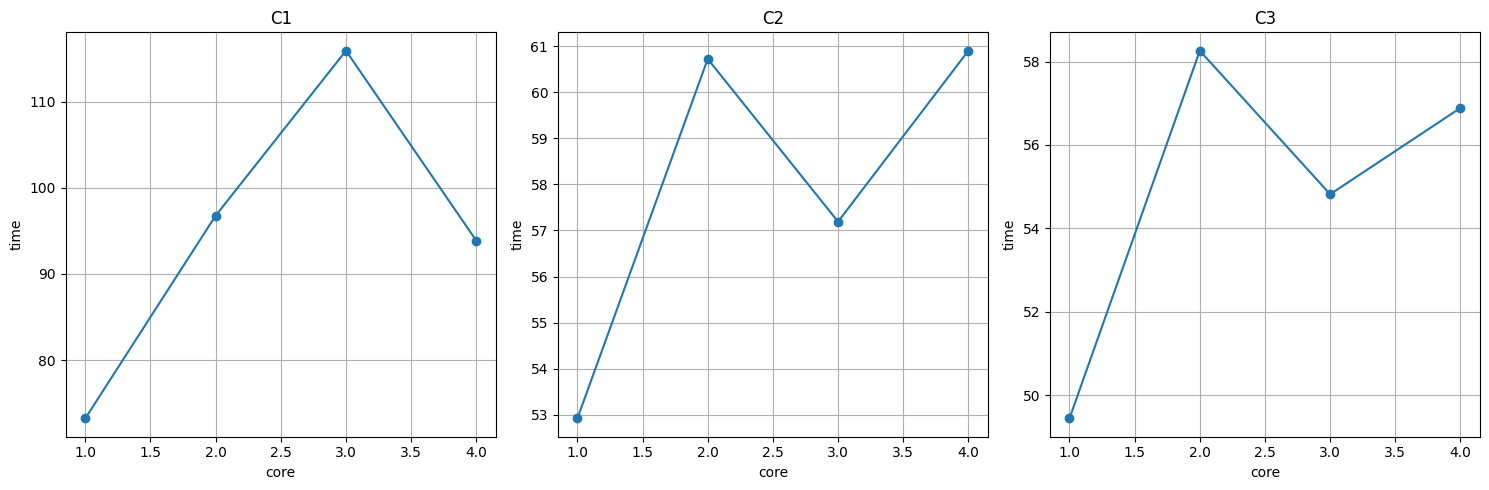

In [25]:
import matplotlib.pyplot as plt

c1_cores = [result[1] for result in c1_results]
c1_times = [result[2] for result in c1_results]

c2_cores = [result[1] for result in c2_results]
c2_times = [result[2] for result in c2_results]

c3_cores = [result[1] for result in c3_results]
c3_times = [result[2] for result in c3_results]


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(c1_cores, c1_times, marker='o')
axs[0].set_title('C1')
axs[0].set_xlabel('core')
axs[0].set_ylabel('time')
axs[0].grid(True)

axs[1].plot(c2_cores, c2_times, marker='o')
axs[1].set_title('C2')
axs[1].set_xlabel('core')
axs[1].set_ylabel('time')
axs[1].grid(True)

axs[2].plot(c3_cores, c3_times, marker='o')
axs[2].set_title('C3')
axs[2].set_xlabel('core')
axs[2].set_ylabel('time')
axs[2].grid(True)


plt.tight_layout()
plt.show();